首先我们要理解一个概念，如果把一张图片的灰度信息当作平面的高度信息，那么当颜色出现变动的时候，就产生了类似梯度一样的概念。所以，在物体与背景之间，由于像素值的巨大变动，往往会出现巨大的梯度差。

锐化算法的本质，就是用数学的方法，调整这个梯度差，比如让这个梯度更为陡峭，于是从视觉上会起到细节增强的作用。

# 锐化滤波器背后的数学知识

![在这里插入图片描述](https://img-blog.csdnimg.cn/20210305212056292.jpg?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3BvaXNvbmNocnk=,size_16,color_FFFFFF,t_70#pic_center)

假设我们有二次函数如上表示，它在某一点的斜率可以用其导数形式进行表示，既有：

$$der(f(x)) = \frac{ f(x+\triangle x) - f(x) }{\triangle x}$$

由小学的数学概念可以得知，如果改变原函数的斜率，那么就可以使得原函数变得更为陡峭或者平缓。但是在一阶导数上进行调整，稍微有些困难，所以通常情况下我们会选择在二阶导数上进行调整。

为了验证这个理论，我们做一个简单的实验，假设原函数为$y=x^2$，它的图像在$x>0$侧表示为：

![在这里插入图片描述](https://img-blog.csdnimg.cn/20210305214033811.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3BvaXNvbmNocnk=,size_16,color_FFFFFF,t_70#pic_center)

其一阶导数为 $der(f(x)) = 2x$，绘制出来的图像是这样的：

![在这里插入图片描述](https://img-blog.csdnimg.cn/20210305214217642.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3BvaXNvbmNocnk=,size_16,color_FFFFFF,t_70#pic_center)

其二阶导数为 $der(der(f(x))) = 2$

![在这里插入图片描述](https://img-blog.csdnimg.cn/2021030521432128.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3BvaXNvbmNocnk=,size_16,color_FFFFFF,t_70#pic_center)

我们给2阶导数乘一个大于1的数，比如1.5，那么原函数就变成了 $f(x) = \frac{3}{2} x^2 + cx$，令$c=0$，那么可以得到这样一个图像

$y=1.5x^2$

![在这里插入图片描述](https://img-blog.csdnimg.cn/2021030521480462.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3BvaXNvbmNocnk=,size_16,color_FFFFFF,t_70#pic_center)

$y=x^2$

![在这里插入图片描述](https://img-blog.csdnimg.cn/20210305214818520.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3BvaXNvbmNocnk=,size_16,color_FFFFFF,t_70#pic_center)

可以发现原函数变得陡峭多了！

# 锐化空间计算公式

由于通过二阶导反推回原函数有一定难度，所以我们需要分析一下其差分形式，

$$\triangledown^2f = \triangledown f(x+1) - \triangledown f(x)$$

而

$$\triangledown f(x) = f(x+1) - f(x)$$

所以，就可以得到这样一个公式

$$f(x) = f(x+1) -  \triangledown f(x)$$

则

$$f(x) = f(x + 1) - \triangledown f(x) + \triangledown^2 f(x)$$

那么，锐化后或者钝化后的实际图像$g(x)$，也就是对 $\triangledown^2 f$ 的乘积 $k$ 就可以简单的变成这样的形式，

$$g(x) = f(x + 1)  - \triangledown f(x) + k \triangledown^2 f(x)$$

在不考虑精确度的情况下，把中间的梯度值设为0后，就可以表示为以下表达式：

$$g(x) = f(x)  + k \triangledown^2 f(x)$$

这个式子的含义，就是求解原图像的二阶导数后得到一个和原图大小一致的矩阵，然后乘以一个系数 $k$后，把修改后的值直接加回原始图像，即可以得到增强或钝化后的图形。

不过在具体实现这个算法前，我想先简单的探讨一下拉普拉斯算子的其他应用，因为这在我们其他应用中也会用到类似的技术。

# 拉普拉斯算子与图像边界

拉普拉斯算子，即二阶偏微分方程，根据二阶导在某些情况下所描述的数学定义，即在区间为 $[a, b]$ 时，为其函数值为正或者负，则原函数是递增或递减，为0则表示不变的特性。

可以知道在大块色块相似的区域内，拉普拉斯算子求解出的值应该为0或接近0的数，只有在色块出现大块颜色区分的时候，拉普拉斯算子才会计算出的大于0或者小于0的数，而这正好对应到图片中物体的边界。

而为了避免 $<0$ 的情况出现，以及无法正确显示边界信息，通常会选择使用它的绝对值信息。所以，如果我们实现一个拉普拉斯算子的程序如下，经过它处理后的图片就会出现这样有趣的效果：

In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# 增强的拉普拉斯算子核函数
def laplacian_operator_mod(image, k):
    # 定义拉普拉斯核
    kernel = np.array([[0, 1, 0],
                       [1, -4, 1],
                       [0, 1, 0]])

    # 使用OpenCV的filter2D进行卷积操作
    laplacian_filtered = cv2.filter2D(image, -1, kernel)

    # 增强效果：对卷积结果乘以系数k，然后叠加回原图
    enhanced_image = image - k * laplacian_filtered

    # 将结果裁剪至0-255的范围，并转换为uint8类型
    enhanced_image = np.clip(enhanced_image, 0, 255)
    
    return enhanced_image.astype(np.uint8)


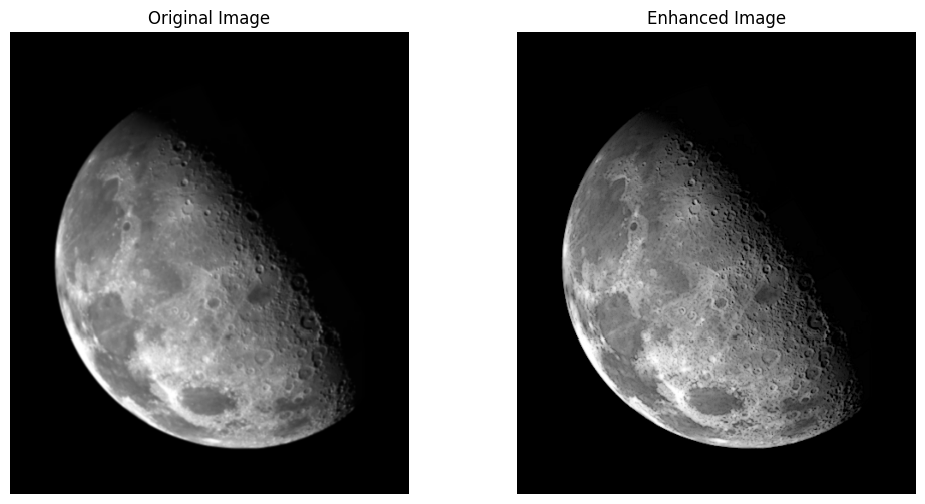

In [2]:
# 加载灰度图像
BASE_DIR = '/opt/images/DIPRawImageDataset/DIP3E_CH04_Original_Images/DIP3E_Original_Images_CH04'
image_path = os.path.join(BASE_DIR, "Fig0458(a)(blurry_moon).tif")
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# 使用增强的拉普拉斯算子
k = 1.5  # 设置增强系数
output = laplacian_operator_mod(image, k)

# 显示原始图像和增强后的图像
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(122)
plt.title("Enhanced Image")
plt.imshow(output, cmap='gray')
plt.axis('off')

plt.show()

# 锐化滤波改进型

锐化滤波有一个比较显著的缺点，就是会同时强化原始图像中的噪点。所以通常的一些改进形方法：

## 改进方法一
一、先使用中值滤波，过滤原始图像中出现的噪点得到输出的图像$g(x,y)$
二、对 $g(x,y)$ 使用拉普拉斯算子，计算它的梯度图像，得到 $lap(x, y)$
三、将得到的 $lap(x,y)$ 用于增强原始图像 $f(x,y)$ 

## 改进方法二
你会注意到，拉普拉斯算子的计算矩阵为

$$\begin{bmatrix}
0 & 1 & 0 \\ 
1 & -4 & 1 \\ 
0 & 1 & 0
\end{bmatrix}$$

其中一种改进型，使用如下计算矩阵：

$$\begin{bmatrix}
1 & 1 & 1 \\ 
1 & -8 & 1 \\ 
1 & 1 & 1
\end{bmatrix}$$

当然，除了这些方法外，还有其他一些改进方法，有兴趣你可以搜一下相关论文，尝试一下各种方法的效果，直到找到一种合适你使用场景的，这里我就不做过多的扩展了。